# **Imports**

In [86]:
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import ConcatDataset, Dataset, DataLoader

# **Data preparation**

## Download CIFAR100

In [99]:
transform = T.Compose([
                T.ToTensor(),
                # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

trainset = torchvision.datasets.CIFAR100('./', True, download=True, transform=transform)
valset = torchvision.datasets.CIFAR100('./', False, download=True, transform=transform)
dataset = ConcatDataset([trainset, valset])
len(dataset)

Files already downloaded and verified
Files already downloaded and verified


60000

In [100]:
num_c_train, num_c_val, num_c_test = 70, 20, 10
c_indices = np.arange(100)
np.random.shuffle(c_indices)
train_classes = c_indices[:num_c_train]
val_classes = c_indices[num_c_train:num_c_train+num_c_val]
test_classes = c_indices[-num_c_test:]

len(train_classes), len(val_classes), len(test_classes)

(70, 20, 10)

## Split CIFAR100 into meta-train, meta-validation and meta-test

In [101]:
train_data, val_data, test_data = [], [], []
for image, label in dataset:
    if label in test_classes:
        test_data.append((image, label))
    elif label in val_classes:
        val_data.append((image, label))
    else:
        train_data.append((image, label))
        
train_data = sorted(train_data, key=lambda x: x[1])
val_data = sorted(val_data, key=lambda x: x[1])
test_data = sorted(test_data, key=lambda x: x[1])
train_classes = np.sort(train_classes)
val_classes = np.sort(val_classes)
test_classes = np.sort(test_classes)

len(train_data), len(val_data), len(test_data)

(42000, 12000, 6000)

In [102]:
class CifarMeta(Dataset):
    def __init__(self, data, c_indices):
        self.data = data
        self.new_indices_dic = {idx:i for i, idx in enumerate(c_indices)}
        self.num_classes = len(c_indices)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        new_label = self.new_indices_dic[label]
        return image, new_label

In [103]:
trainset = CifarMeta(train_data, train_classes)
valset = CifarMeta(val_data, val_classes)
testset = CifarMeta(test_data, test_classes)

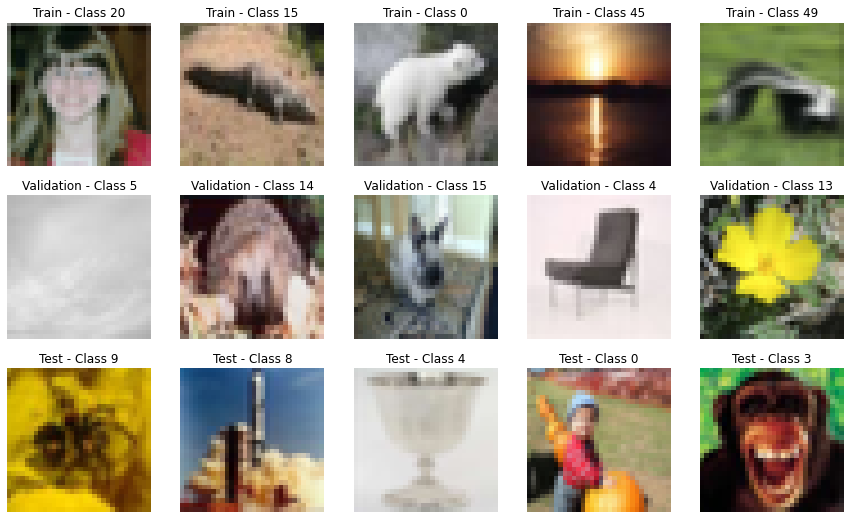

In [104]:
fig = plt.figure(figsize=(15, 9))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    image, label = trainset[np.random.randint(0, len(trainset))]                                         
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title('Train - Class {}'.format(label))
    ax.axis('off')

for i in range(5):
    ax = plt.subplot(3, 5, i+6)
    image, label = valset[np.random.randint(0, len(valset))]                                         
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title('Validation - Class {}'.format(label))
    ax.axis('off')

for i in range(5):
    ax = plt.subplot(3, 5, i+11)
    image, label = testset[np.random.randint(0, len(testset))]                                         
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title('Test - Class {}'.format(label))
    ax.axis('off')


## Create batch sampler

In [105]:
class BatchSampler():

    def __init__(self, iters, dataset, ways, shots, batch_size=1, per_class=600):
        self.iters = iters
        self.dataset = dataset
        self.ways = ways
        self.shots = shots
        self.per_class = per_class
        self.batch_size = batch_size

    def __iter__(self):
        for it in range(self.iters):
            support = np.array([])
            query = np.array([])
            total_classes = self.dataset.num_classes
            indices = np.arange(total_classes)
            chosen_classes = np.random.choice(indices, size=self.ways, replace=False)
            for cc in chosen_classes:
                begin = cc * self.per_class
                end = begin + self.per_class
                support_query = np.random.choice(np.arange(begin, end), size=self.shots*2, replace=False)
                support = np.concatenate([support, support_query[:self.shots]])
                query = np.concatenate([query, support_query[self.shots:]])
            total_batch_indexes = np.concatenate([support, query])
            yield total_batch_indexes.astype(int)

    def __len__(self):
        return self.iters

# **Model Definition**

## ProtoNetBack

In [82]:
def conv_block(in_channels, out_channels):
    '''
    returns a block conv-bn-relu-pool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )


class ProtoNetBack(nn.Module):
    def __init__(self, input_channels = 1):
        super(ProtoNetBack, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, 64, 1),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 64),
        )

    def get_embedding_size(self, input_size = (1,28,28)):
        device = next(self.parameters()).device
        x = torch.rand([2,*input_size]).to(device)
        with torch.no_grad():
            output = self.forward(x)
            emb_size = output.shape[-1]
        
        del x,output
        torch.cuda.empty_cache()

        return emb_size

    def forward(self, x):
        return self.layers (x).reshape ([x.shape[0] , -1])

## Model

In [124]:
class EmbeddingFunction(nn.Module):

    def __init__(self, inshape, M):
        super(EmbeddingFunction, self).__init__()
        input_channels = inshape[0]
        self.M = M
        
        self.p_back = ProtoNetBack(input_channels)
        D = self.p_back.get_embedding_size(inshape)
        self.fc1 = nn.Linear(D, 128)
        self.fc2 = nn.Linear(128, M)

    def __compute_distance(self, x, c):
        t1 = (x ** 2).sum(dim=1).view((-1, 1))
        t2 = (c ** 2).sum(dim=1).view((1, -1))
        t3 = 2 * (x @ c.T)
        dist_mat = t1 + t2 - t3
        return dist_mat

    def forward(self, x, n, k):
        l = n * k
        x = self.p_back(x)
        x = F.relu(x, inplace=True)
        x = self.fc1(x)
        x = F.relu(x, inplace=True)
        embeddings = self.fc2(x)                                                # embeddings: (2L, M)

        support_embeddings = embeddings[:l, :]                                  # support: (L, M)
        query_embeddings = embeddings[l:, :]                                    # query: (L, M)
        centroids = support_embeddings.reshape((n, k, self.M))                  # centroids: (N, K, M)
        centroids = centroids.mean(dim=1)                                       # centroids: (N, M) 

        dist_mat = self.__compute_distance(query_embeddings, centroids)         # dist_mat: (L, N) 
        return -dist_mat

# **Train**

In [137]:
def train(train_ways, train_shots, test_ways, test_shots, epochs=1):

    # GPU or CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device: {}'.format(device))

    # Dataloaders
    train_iters = 1000
    val_iters = 100
    trainloader = DataLoader(trainset, batch_sampler=BatchSampler(train_iters, trainset, train_ways, train_shots))
    valloader = DataLoader(valset, batch_sampler=BatchSampler(val_iters, valset, test_ways, test_shots))

    # Hyperparams and model definition
    lr = 1e-3
    M = 128
    net = EmbeddingFunction((3, 32, 32), M).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Begin training
    net.train()
    print('Number of iterations in each epoch: {}'.format(len(trainloader)))
    print('Number of validation iterations: {}'.format(len(valloader)))
    print('Training started ...')
    epoch_train_loss = 0.0
    epoch_train_acc = 0.0
    epoch_count = 0.0
    log_every_iter = 50
    
    for epoch in range(epochs):

        running_loss = 0.0
        running_lp_fraction = 0.0
        running_accuracy = 0.0
        tick = time.time()
        t = time.time()

        # ======================================================================
        # Train
        net.train()
        for i, data in enumerate(trainloader, 0):
            
            overhead_duration = time.time() - t
            t = time.time()

            inputs, _ = data
            labels = torch.repeat_interleave(torch.arange(train_ways), train_shots)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs, train_ways, train_shots)
            loss = F.cross_entropy(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, axis=1)
            acc = ((preds == labels) * 1.0).mean()

            running_loss += loss.item()
            running_accuracy += acc.item()
            epoch_train_loss += loss.item() * inputs.shape[0]
            epoch_train_acc += acc.item() * inputs.shape[0]
            epoch_count += inputs.shape[0]

            processing_duration = time.time() - t
            t = time.time()
            running_lp_fraction += overhead_duration / processing_duration

            if i % log_every_iter == log_every_iter - 1:
                tock = time.time()
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / log_every_iter:.3f}, \
                        accuracy = {running_accuracy / log_every_iter:.4f}')
                tick = time.time()
                running_loss = 0.0
                running_lp_fraction = 0.0
                running_accuracy = 0.0
        
        # ======================================================================
        # Eval
        print('------------- Validation -------------')
        net.eval()
        running_accuracy = 0.0
        for i, data in enumerate(valloader, 0):
            inputs, _ = data
            labels = torch.repeat_interleave(torch.arange(test_ways), test_shots)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs, test_ways, test_shots)
            preds = torch.argmax(outputs, axis=1)
            acc = ((preds == labels) * 1.0).mean()
            running_accuracy += acc.item()
        print(f'Validation accuracy: {running_accuracy / len(valloader)}')

    return net

In [138]:
def test(net, test_ways, test_shots):
    print('------------- Evaluation on test data -------------')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_iters = 100
    testloader = DataLoader(testset, batch_sampler=BatchSampler(test_iters, testset, test_ways, test_shots))
    net.eval()
    running_accuracy = 0.0
    for i, data in enumerate(testloader, 0):
        inputs, _ = data
        labels = torch.repeat_interleave(torch.arange(test_ways), test_shots)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs, test_ways, test_shots)
        preds = torch.argmax(outputs, axis=1)
        acc = ((preds == labels) * 1.0).mean()
        running_accuracy += acc.item()
    acc = running_accuracy / len(testloader)
    print(f'Test accuracy: {acc}')
    return acc

## Part A

In [140]:
net = train(10, 8, 10, 8, 3)
acc = test(net, 10, 8)

Device: cuda
Number of iterations in each epoch: 1000
Number of validation iterations: 100
Training started ...
[1,    50] loss: 1.863,                         accuracy = 0.3418
[1,   100] loss: 1.820,                         accuracy = 0.3603
[1,   150] loss: 1.704,                         accuracy = 0.3988
[1,   200] loss: 1.716,                         accuracy = 0.4010
[1,   250] loss: 1.607,                         accuracy = 0.4358
[1,   300] loss: 1.558,                         accuracy = 0.4490
[1,   350] loss: 1.583,                         accuracy = 0.4460
[1,   400] loss: 1.500,                         accuracy = 0.4815
[1,   450] loss: 1.528,                         accuracy = 0.4598
[1,   500] loss: 1.469,                         accuracy = 0.4860
[1,   550] loss: 1.432,                         accuracy = 0.4970
[1,   600] loss: 1.443,                         accuracy = 0.4865
[1,   650] loss: 1.382,                         accuracy = 0.5295
[1,   700] loss: 1.356,       

In [142]:
print(f'Test accuracy is: {acc}')

Test accuracy is: 0.551125011742115


## Part B

In [143]:
ways = 10
all_shots = [1, 2, 4, 8, 16]
accuracies = []
for shots in all_shots:
    print(f'============================== {ways} ways, {shots} shots ==============================')
    net = train(ways, shots, ways, shots, 3)
    acc = test(net, ways, shots)
    accuracies.append(acc)

============================== 10 ways, 1 shots ==============================
Device: cuda
Number of iterations in each epoch: 1000
Number of validation iterations: 100
Training started ...
[1,    50] loss: 2.344,                         accuracy = 0.1860
[1,   100] loss: 2.238,                         accuracy = 0.1720
[1,   150] loss: 2.238,                         accuracy = 0.2180
[1,   200] loss: 2.211,                         accuracy = 0.1980
[1,   250] loss: 2.206,                         accuracy = 0.2140
[1,   300] loss: 2.193,                         accuracy = 0.2040
[1,   350] loss: 2.188,                         accuracy = 0.2120
[1,   400] loss: 2.190,                         accuracy = 0.2120
[1,   450] loss: 2.181,                         accuracy = 0.2000
[1,   500] loss: 2.172,                         accuracy = 0.2200
[1,   550] loss: 2.195,                         accuracy = 0.2060
[1,   600] loss: 2.168,                         accuracy = 0.2200
[1,   650] loss: 

Text(0, 0.5, 'Accuracy')

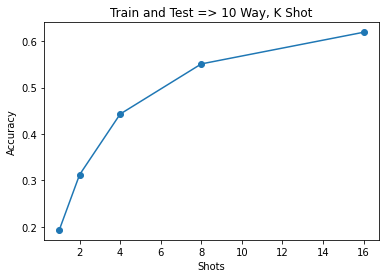

In [144]:
plt.scatter(all_shots, accuracies)
plt.plot(all_shots, accuracies)
plt.title('Train and Test => 10 Way, K Shot')
plt.xlabel('Shots')
plt.ylabel('Accuracy')

## Part C

In [145]:
all_ways = [2, 4, 8, 16, 32]
shots = 5
accuracies = []
for ways in all_ways:
    print(f'============================== {ways} ways, {shots} shots ==============================')
    net = train(ways, shots, 10, shots, 3)
    acc = test(net, 10, shots)
    accuracies.append(acc)

============================== 2 ways, 5 shots ==============================
Device: cuda
Number of iterations in each epoch: 1000
Number of validation iterations: 100
Training started ...
[1,    50] loss: 0.659,                         accuracy = 0.6860
[1,   100] loss: 0.565,                         accuracy = 0.7040
[1,   150] loss: 0.591,                         accuracy = 0.6940
[1,   200] loss: 0.618,                         accuracy = 0.6660
[1,   250] loss: 0.573,                         accuracy = 0.7140
[1,   300] loss: 0.567,                         accuracy = 0.7200
[1,   350] loss: 0.587,                         accuracy = 0.7120
[1,   400] loss: 0.544,                         accuracy = 0.7500
[1,   450] loss: 0.558,                         accuracy = 0.7280
[1,   500] loss: 0.610,                         accuracy = 0.6880
[1,   550] loss: 0.591,                         accuracy = 0.7060
[1,   600] loss: 0.597,                         accuracy = 0.6940
[1,   650] loss: 0

Text(0, 0.5, 'Accuracy')

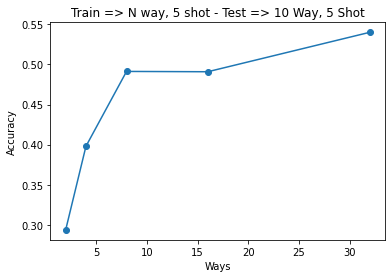

In [146]:
plt.scatter(all_ways, accuracies)
plt.plot(all_ways, accuracies)
plt.title('Train => N way, 5 shot - Test => 10 Way, 5 Shot')
plt.xlabel('Ways')
plt.ylabel('Accuracy')

## Part D

In [147]:
net = train(10, 10, 10, 10, 3)
all_shots = [1, 5, 10, 15, 20]
ways = 10
accuracies = []
for shots in all_shots:
    print(f'============================== {ways} ways, {shots} shots ==============================')
    acc = test(net, ways, shots)
    accuracies.append(acc)

Device: cuda
Number of iterations in each epoch: 1000
Number of validation iterations: 100
Training started ...
[1,    50] loss: 1.817,                         accuracy = 0.3692
[1,   100] loss: 1.765,                         accuracy = 0.3908
[1,   150] loss: 1.661,                         accuracy = 0.4214
[1,   200] loss: 1.641,                         accuracy = 0.4248
[1,   250] loss: 1.523,                         accuracy = 0.4674
[1,   300] loss: 1.493,                         accuracy = 0.4802
[1,   350] loss: 1.418,                         accuracy = 0.5058
[1,   400] loss: 1.423,                         accuracy = 0.5034
[1,   450] loss: 1.384,                         accuracy = 0.5214
[1,   500] loss: 1.359,                         accuracy = 0.5240
[1,   550] loss: 1.306,                         accuracy = 0.5400
[1,   600] loss: 1.285,                         accuracy = 0.5490
[1,   650] loss: 1.316,                         accuracy = 0.5410
[1,   700] loss: 1.273,       

Text(0, 0.5, 'Accuracy')

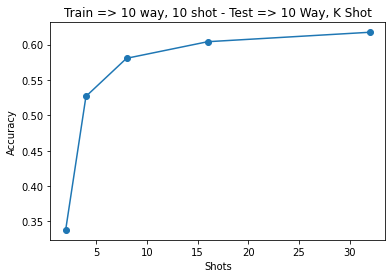

In [148]:
plt.scatter(all_ways, accuracies)
plt.plot(all_ways, accuracies)
plt.title('Train => 10 way, 10 shot - Test => 10 Way, K Shot')
plt.xlabel('Shots')
plt.ylabel('Accuracy')